In [1]:
import numpy as np
from scipy import sparse
from scipy import linalg
import mat73
import scipy.io as sio
from matplotlib import pyplot as plt

## Loading and Creation Data

### _loadDataFromFile_

This function permits to load large sparse matrix from [https://sparse.tamu.edu/](https://sparse.tamu.edu/).

In [2]:
def load_data_from_file(path:str):
    try:
        data_dict = mat73.loadmat(path)
    except:
        print('Vecchio formato')
        data_dict = sio.loadmat(path)

    return data_dict

### _generateData_

This function permit to create (randomly), the initial data for GMRES:
- `A`: the sparse coefficient matrix of the Linear System
- `b`: the known therm vector
- `x0`: initial guess

In [3]:
def generateData(dim: int, den: float, seed=69):
    np.random.seed(seed)
    
    A = sparse.random(dim, dim, den, format="csr", dtype=np.float64)
    b = sparse.random(dim, 1, .1, format="csr")
    x0 = sparse.csr_matrix((dim, 1))
        
    return A, b, x0

### _generateData2_

This function permit to create (randomly), the initial data for GMRES using some conditioning in order to obtain convergence:
- `A`: the coefficient matrix of the Linear System
- `b`: the known therm vector
- `x0`: initial guess

In [4]:
def generateData2(dim: int, n=-4, seed=69):
    np.random.seed(seed)
    mu = 0
    sigma = 1/(2*np.sqrt(dim))
    
    A = (np.eye(dim) * n) + np.random.normal(mu, sigma, (dim, dim))
    b = sparse.csr_matrix(np.ones((dim, 1)))
    
    if randx0:
        x0 = np.random.random((dim, 1))
    else:
        x0 = np.zeros((dim, 1))
        
    return A, b, x0

## Auxiliary functions

### _plotResiduals_

Function to plot GMRES' residuals

In [5]:
def plot_residuals(res, all=False):
    if all:
        plt.plot(res, scalex=True, scaley=True)
        plt.title("Residual over Iteration")
        plt.xlabel("Iterations")
        plt.ylabel("Residual Values")
        plt.show()
        
    plt.semilogy(res, scalex=True, scaley=True)
    plt.title("Residual over Iteration (semilog scale)")
    plt.xlabel("Iterations")
    plt.ylabel("Residual Values")
    plt.show()
    

### _plotFunction_

Auxiliary functions to plot matrix and eigenvalue informations.

In [6]:
def plot_matrix(A, figTitle="Matrix"):
    plt.spy(A[:50, :50])
    # plt.colorbar()
    plt.title(figTitle)
    plt.show()
    
def plot_eig(A, figTitle="Eigenvalues"):
    # print(sparse.linalg.eigs(A))
    plt.plot(sparse.linalg.eigs(A, k=int(A.shape[0]/2) ,return_eigenvectors=True)[0], 'o')
    plt.title(figTitle)
    plt.show()
    
def matrix_info(A, title1="Matrix", title2="Eigenvalues"):
    plot_matrix(A, title1)
    plot_eig(A, title2)

## GMRES Implementation

In [7]:
def gmres(A, b, x0, k, tol):
    res = []
    n = b.shape[0]
    r0 = b - A @ x0
    
    beta = sparse.linalg.norm(r0)
    
    H = sparse.lil_matrix((k+2, k+1))
    Q = sparse.lil_matrix((n, k+1))
    # H = np.zeros((k+2, k+1))
    # Q = np.zeros((n, k+1))
    
    Q[:, [0]] = r0 / beta
    
    en = np.zeros((k+2, 1))
    en[0] = 1
    
    for j in range(k):
        v = A @ Q[:, [j]]
        
        for _ in range(2):
            for i in range(j+1):
                # tmp = (Q[:, [i]].T @ v).todense()
                tmp = (Q[:, [i]].T @ v)[0, 0]
                
                # print(tmp)
                
                v = v - Q[:, [i]] * tmp
                H[i, j] = H[i, j] + tmp
        
        H[j+1, j] = sparse.linalg.norm(v)
                
        if H[j+1, j] == 0:
            raise ValueError("Divisione per 0 !!")
        
        Q[:, [j+1]] = v / H[j+1, j]
        e1 = en[:j+2]
        
        y = sparse.linalg.lsqr(H[:j+2, :j+1], beta*e1)[0]
        res.append(linalg.norm(H[:j+2, :j+1] @ y - beta * e1, 2))
        
        if res[-1] < tol:
            # print(f"H shape: {H.shape}")
            print(f"🚀 Raggiunta Tolleranza (j: {j+1}), stop")
            
            x = Q[:, :j+1] @ y + x0
            
            # plt.matshow(H[:j, :j])
            plt.matshow(H[:j+1, :j+1])
            plt.colorbar()
            plt.title("Matrix H")
            plt.show()
            
            return x, res
    
    x = (Q[:, :j+1] @ y).reshape(Q.shape[0], 1) + x0
    
    # print(f"H shape: {H.shape}")
    print("🐌 Raggiunto massimo numero di Iterazioni")
    
    plt.spy(H)
    plt.title("Matrix H")
    plt.show()
    
    return x, res
        

### GMRES with Restarting

In [27]:
# TODO:

## TESTS

### Test 1 - Random Matrix

GMRES test using small random data

In [34]:
A, b, x0 = generateData(300, .5)

GMRES with iteration and `tol = 1e-10`.

🐌 Raggiunto massimo numero di Iterazioni


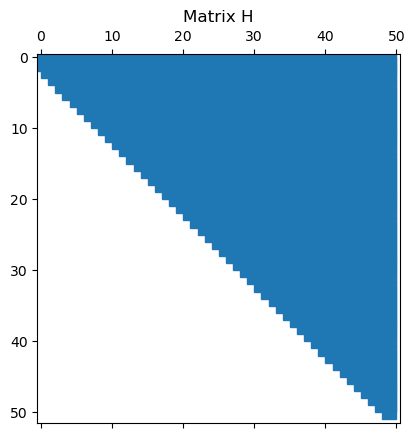

In [35]:
x, res = gmres(A, b, x0, 50, 1e-10)

#### Residual Plot

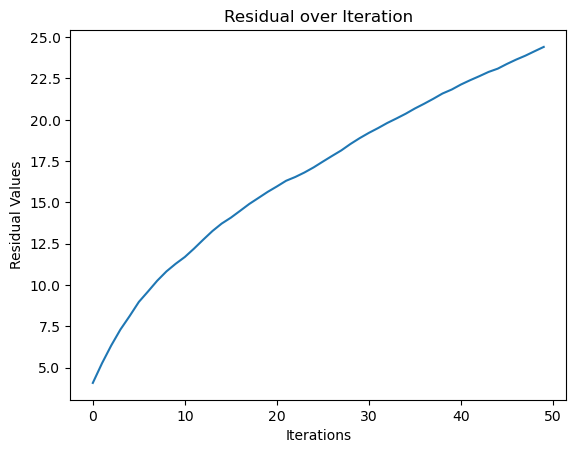

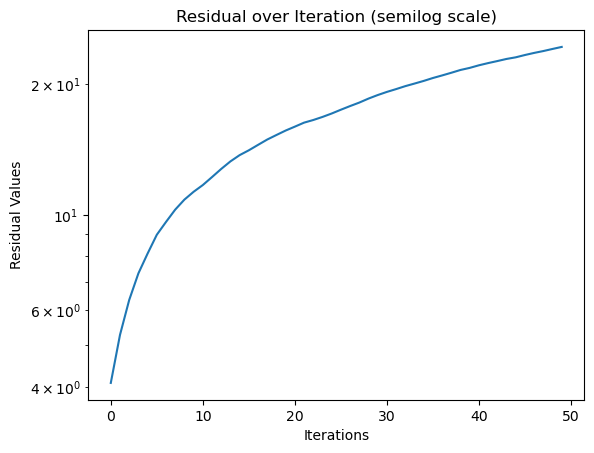

In [36]:
plot_residuals(res, all=True)

We can see that in this execution GMRES is not able to converge.

**Now we can try to iterate for n iteration with n equal to A dimension and verify that GMRES converge to an exact solution.**

🚀 Raggiunta Tolleranza (j: 300), stop


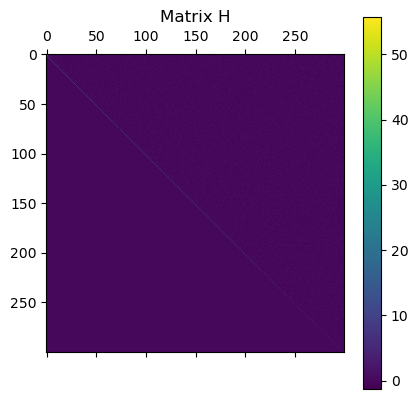

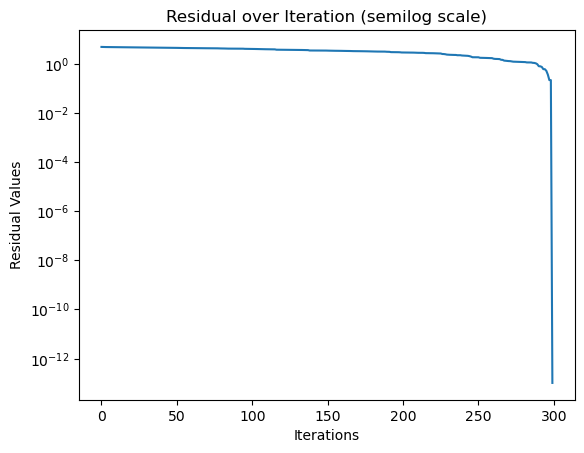

In [13]:
x, res = gmres(A, b, x0, 300, 1e-10)
plot_residuals(res)

### Test 2

**We can explore deeper the matrix composition, in order to see which common property they are**.

Generate 4 different linear systems with a dimension between [50, 800] (in order to obtain a fast eigenvalue computation).

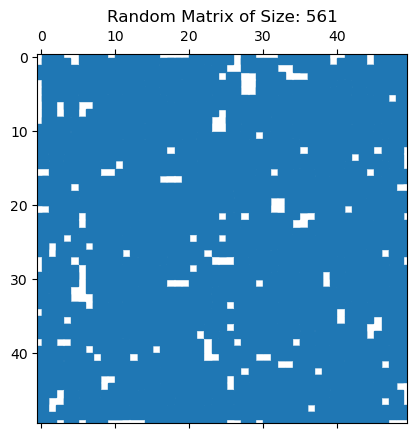

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


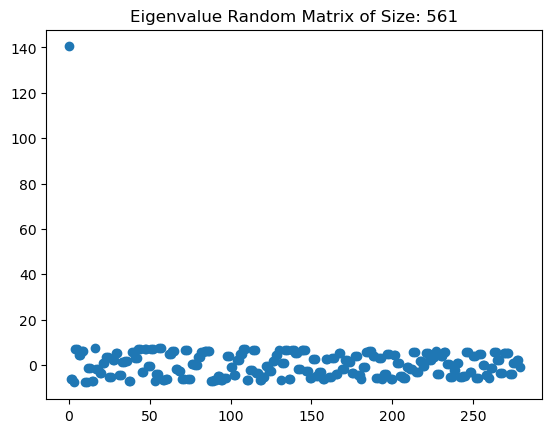

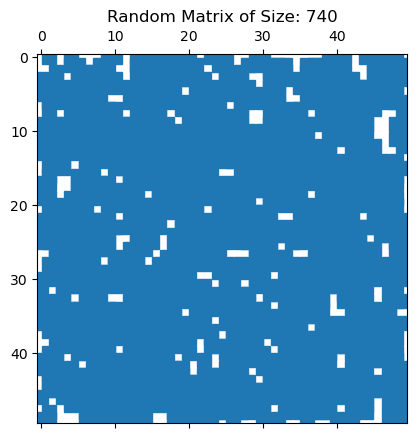

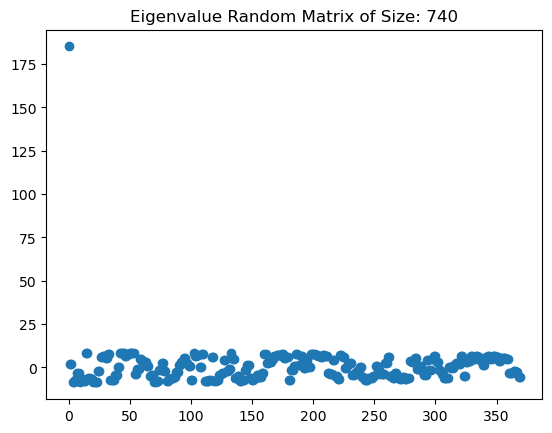

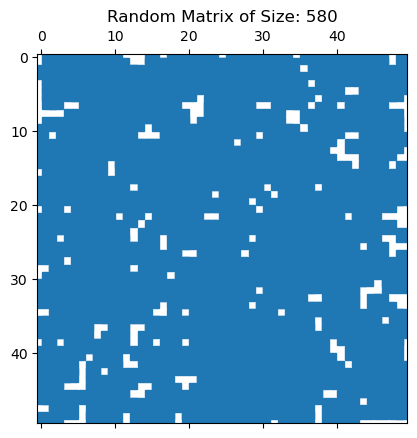

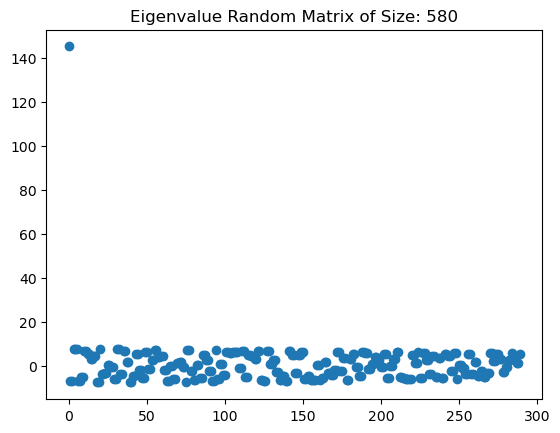

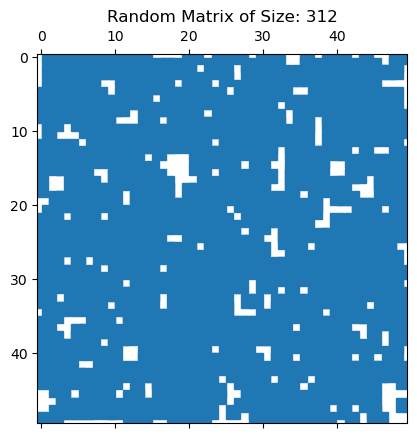

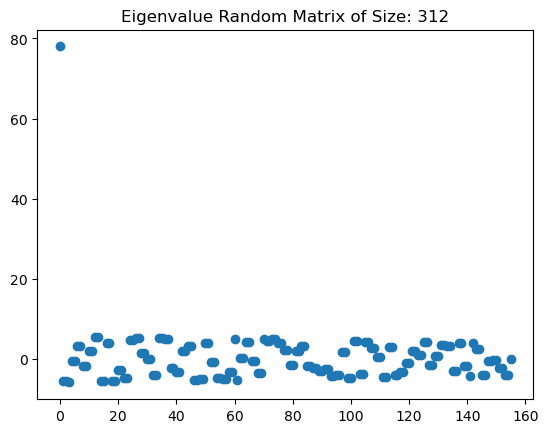

In [18]:
for _ in range(4):
    # 50 <= random size <= 800
    dim = np.random.randint(50, 800)
    
    A, b, x0 = generateData(dim, .5)
    # print(A)
    matrix_info(
        A,
        title1=f"Random Matrix of Size: {dim}" ,
        title2=f"Eigenvalue Random Matrix of Size: {dim}"
    )

### Test 3

Apply GMRES to a linear system with A that corresponds to identity matrix.

🚀 Raggiunta Tolleranza (j: 1), stop


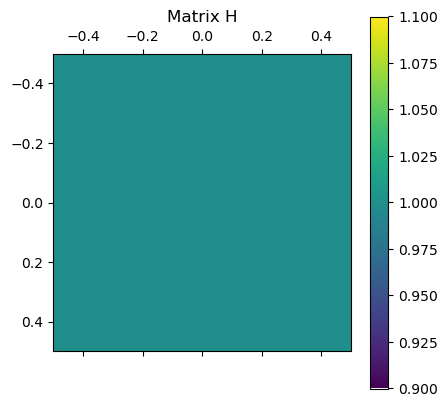

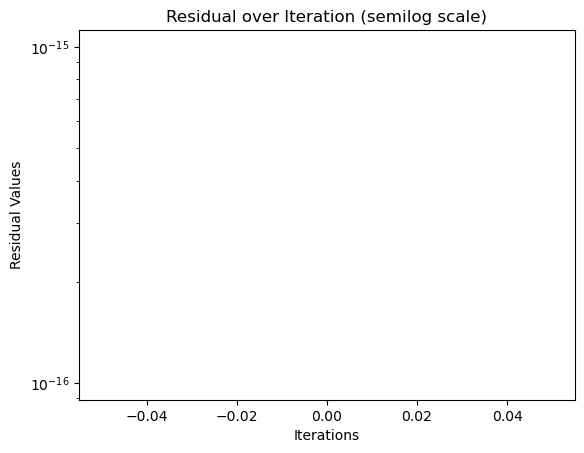

In [19]:
A, b, x0 = generateData(300, .5)
A = np.eye(300)

x, res = gmres(A, b, x0, 150, 1e-10)

plot_residuals(res)

### Test 4

Random matrix + multiple of identity matrix.

🐌 Raggiunto massimo numero di Iterazioni


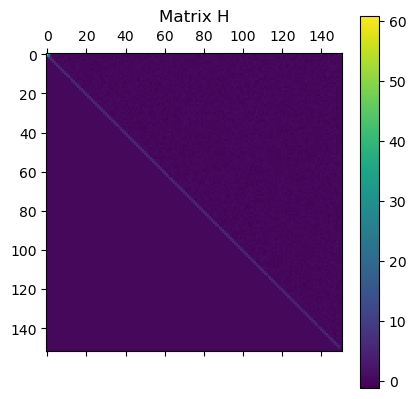

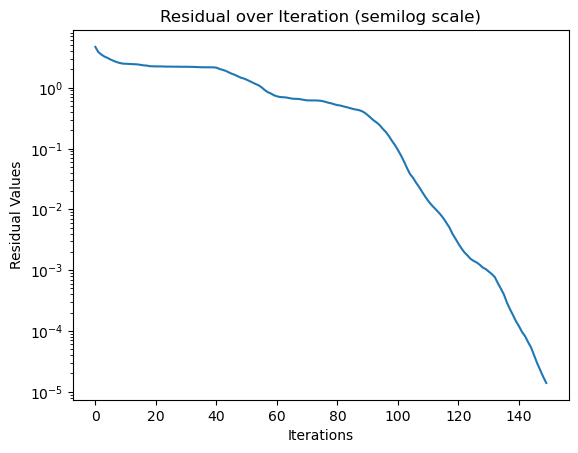

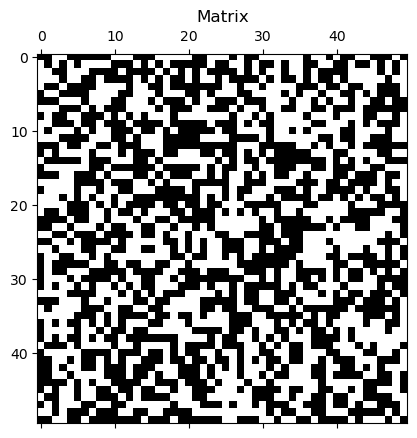

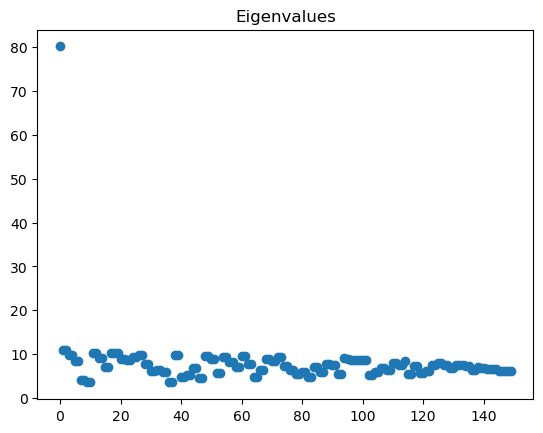

In [21]:
A, b, x0 = generateData(300, .5)

A = A + np.eye(300) * 5

x, res = gmres(A, b, x0, 150, 1e-10)
plot_residuals(res)
matrix_info(A)

### Test 5

Use generateData2.

🚀 Raggiunta Tolleranza (j: 13), stop


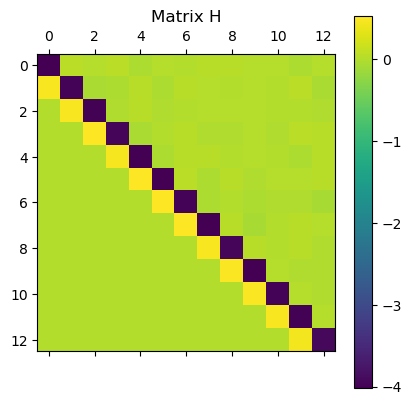

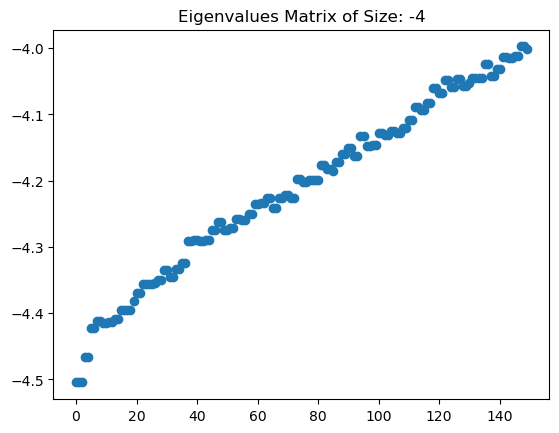

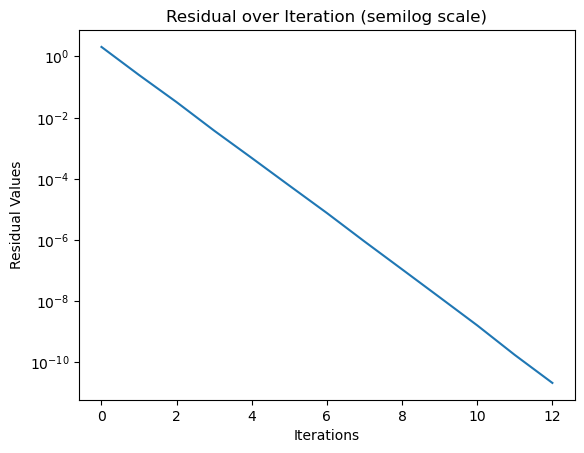

🐌 Raggiunto massimo numero di Iterazioni


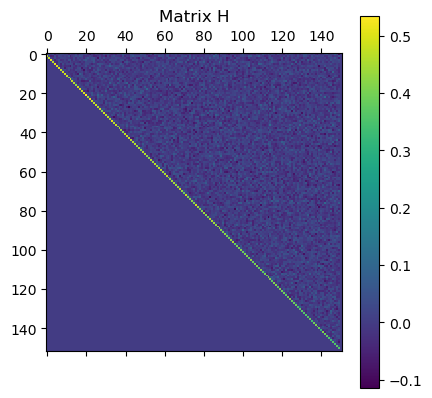

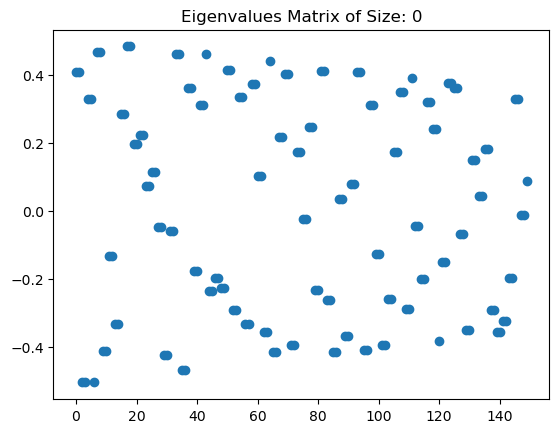

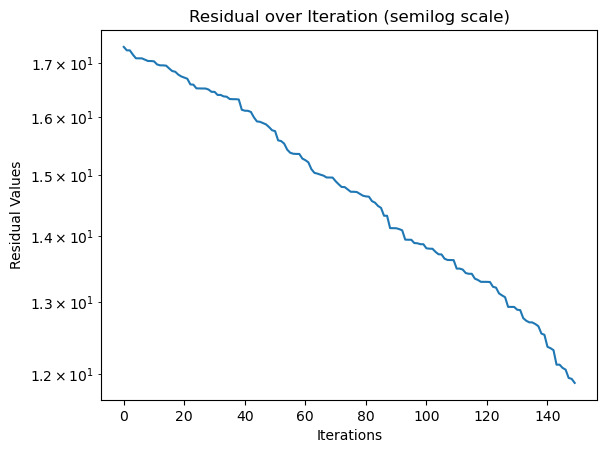

🚀 Raggiunta Tolleranza (j: 13), stop


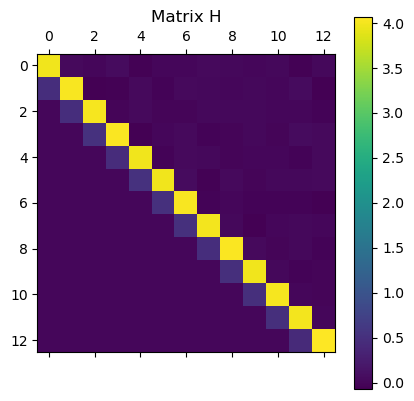

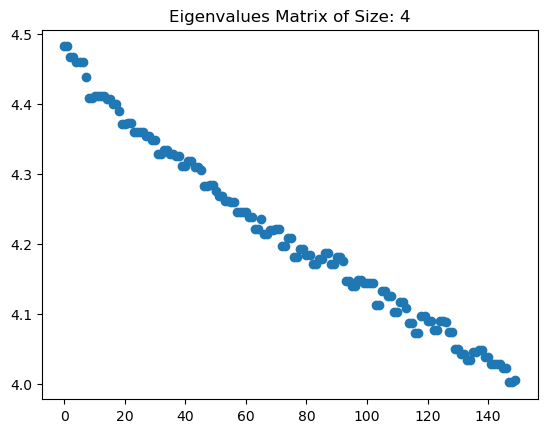

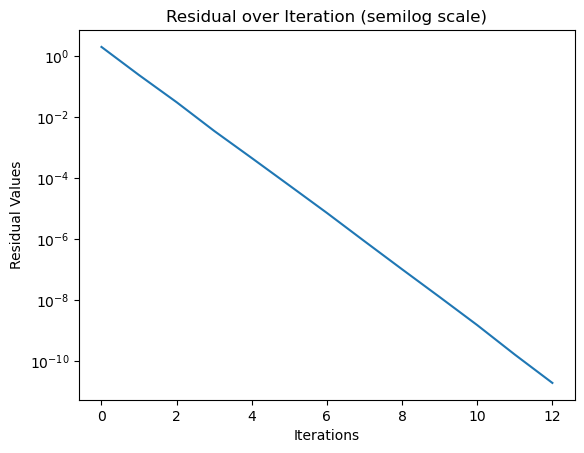

In [22]:
for n in [-4, 0, 4]:
    A, b, x0 = generateData2(300, n=n)
    x, res = gmres(A, b, x0, 150, 1e-10)
    
    x_true = linalg.solve(A, b)
    approx_error = linalg.norm(x_true-x, 2)
    
    plot_eig(A, figTitle=f"Eigenvalues Matrix of Size: {n}")
    plot_residuals(res)

## GMRES with Big Data

Try GMRES with large sparse matrix

In [7]:
%%time
[A, b, x0] = generateData(10000, .5);

CPU times: user 5.73 s, sys: 223 ms, total: 5.95 s
Wall time: 5.95 s


🐌 Raggiunto massimo numero di Iterazioni


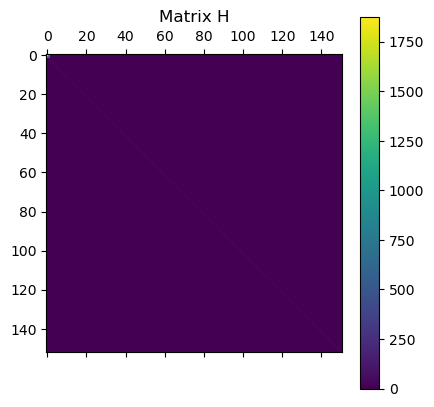

CPU times: user 10.1 s, sys: 15 s, total: 25.2 s
Wall time: 5.85 s


In [8]:
%%time
x, res = gmres(A, b, x0, 150, 1e-10)

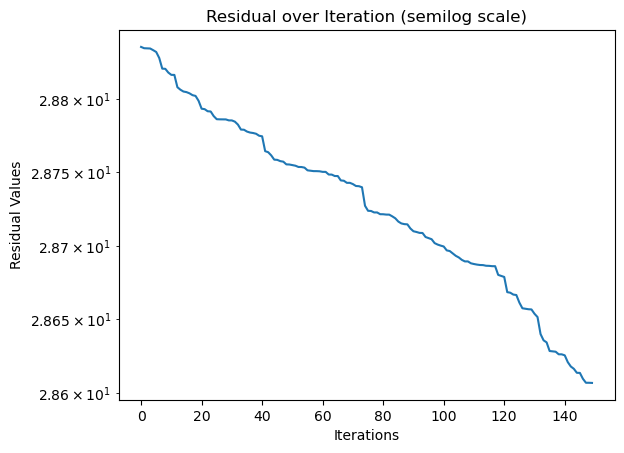

In [9]:
plot_residuals(res)

In [27]:
%%time
A, b, x0 = generateData3(100000, .1)
x, res = gmres(A, b, x0, 150, 1e-10)
plotResiduals(res);

MemoryError: Unable to allocate 74.5 GiB for an array with shape (10000000000,) and data type int64

In [4]:
import mat73
import scipy.io as sio

def loadmatrix(path:str):
    try:
        data_dict = mat73.loadmat(path)
    except:
        print('Vecchio formato')
        data_dict = sio.loadmat(path)

    return data_dict

In [33]:
data_dict = loadmatrix("../data/vas_stokes_4M.mat")

In [34]:
A = data_dict['Problem']['A']
dim = A.shape[0]
b = sparse.random(dim, 1, .1, format="csr")
x0 = sparse.csr_matrix((dim, 1))
# x0 = np.zeros((dim, 1))

# print(A)

In [35]:
A.shape

(4382246, 4382246)

In [15]:
data_dict['Problem'].shape

(1, 1)

In [36]:
x, res = gmres(A, b, x0, 50, 1e-10)

KeyboardInterrupt: 

H shape: (52, 51)
🚀 Raggiunta Tolleranza (j: 40), stop


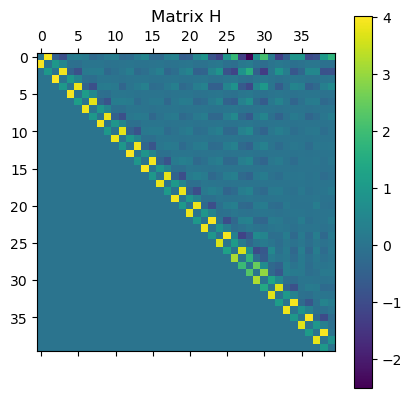

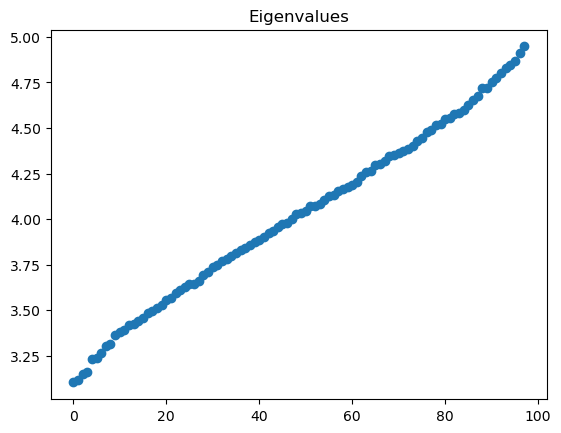

In [99]:
A, b, x0 = generateData2(100, n=4)
x, res = gmres(A, b, x0, 50, 1e-10)
plot_eig(A)